In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import re
import string
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/ikripaka/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ikripaka/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ikripaka/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ikripaka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Вичитуємо датасет відгуків із інтернет магазину Amazon
[**Amazon reviews**](https://www.kaggle.com/datasets/kritanjalijain/amazon-reviews?select=test.csv)

1 -- negative
2 -- positive

In [15]:
df = pd.read_csv('amazon_reviews.csv',  header=None, nrows=40000)
df.columns = ['Polarity', 'Title', 'Review']
df.shape

(40000, 3)

In [16]:
df.head()

,Polarity,Title,Review
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...


## Препроцесинг

In [17]:
# Відділяємо непотрібну колонку
Data = df[['Polarity', 'Review']].reset_index(drop=True)
Data.head(10)

,Polarity,Review
0,2,My lovely Pat has one of the GREAT voices of h...
1,2,Despite the fact that I have only played a sma...
2,1,I bought this charger in Jul 2003 and it worke...
3,2,Check out Maha Energy's website. Their Powerex...
4,2,Reviewed quite a bit of the combo players and ...
5,1,I also began having the incorrect disc problem...
6,1,"I love the style of this, but after a couple y..."
7,1,I cannot scroll through a DVD menu that is set...
8,2,"Exotic tales of the Orient from the 1930's. ""D..."
9,1,"Firstly,I enjoyed the format and tone of the b..."


In [18]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Polarity  40000 non-null  int64 
 1   Review    40000 non-null  object
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [19]:
# нема жодних нульових параметрів
df.isnull().sum()

Polarity    0
Title       3
Review      0
dtype: int64

## Токенізація

In [20]:
# Токенізуймо дял прикладу один відгук
print(Data['Review'][0])
words = word_tokenize(Data['Review'][0])
words

My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I'm in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life's hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing "Who was that singing ?"


['My',
 'lovely',
 'Pat',
 'has',
 'one',
 'of',
 'the',
 'GREAT',
 'voices',
 'of',
 'her',
 'generation',
 '.',
 'I',
 'have',
 'listened',
 'to',
 'this',
 'CD',
 'for',
 'YEARS',
 'and',
 'I',
 'still',
 'LOVE',
 'IT',
 '.',
 'When',
 'I',
 "'m",
 'in',
 'a',
 'good',
 'mood',
 'it',
 'makes',
 'me',
 'feel',
 'better',
 '.',
 'A',
 'bad',
 'mood',
 'just',
 'evaporates',
 'like',
 'sugar',
 'in',
 'the',
 'rain',
 '.',
 'This',
 'CD',
 'just',
 'oozes',
 'LIFE',
 '.',
 'Vocals',
 'are',
 'jusat',
 'STUUNNING',
 'and',
 'lyrics',
 'just',
 'kill',
 '.',
 'One',
 'of',
 'life',
 "'s",
 'hidden',
 'gems',
 '.',
 'This',
 'is',
 'a',
 'desert',
 'isle',
 'CD',
 'in',
 'my',
 'book',
 '.',
 'Why',
 'she',
 'never',
 'made',
 'it',
 'big',
 'is',
 'just',
 'beyond',
 'me',
 '.',
 'Everytime',
 'I',
 'play',
 'this',
 ',',
 'no',
 'matter',
 'black',
 ',',
 'white',
 ',',
 'young',
 ',',
 'old',
 ',',
 'male',
 ',',
 'female',
 'EVERYBODY',
 'says',
 'one',
 'thing',
 '``',
 'Who',
 'was

## Фільтрація / видалення стоп-слів, пунктуації

In [21]:
def clean_text(text): 
    text = str(text) # Конвертація вхідного тексту у строку
    text = text.lower() #Перетворення тексту у нижній регістр
    text = re.sub("\d", " ", text) #Видалення всіх цифр з тексту та заміна їх на пробіли
    text = re.sub("@\S+", " ", text) #Видалення слів, які починаються з символу "@" та заміна їх на пробіли
    text = re.sub("https*\S+", " ", text) #Видалення посилань та заміна на пробіли
    text = re.sub("#\S+", " ", text) #Видалення слів, які починаються з символу "#"
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) #Видалення всіх знаків пунктуації
    text = re.sub('\n', ' ', text) #Видалення символів нового рядка
    text = re.sub('\s{2,}',' ', text)  #Заміна двох або більше пробілів на один
    stop_words = stopwords.words("english") #Створення списку стоп-слів для англ. мови за допомогою бібліотеки nltk
    text = ' '.join([word for word in text.split(' ') if word not in stop_words]) #Розбиття тексту на слова, видалення стоп-слів і з'єднання залишених слів назад в текст
    return text

In [22]:
Data['Review'] = [clean_text(review) for review in Data['Review']]
Data

,Polarity,Review
0,2,lovely pat one great voices generation listene...
1,2,despite fact played small portion game music h...
2,1,bought charger jul worked ok design nice conve...
3,2,check maha energy website powerex mh c f charg...
4,2,reviewed quite bit combo players hesitant due ...
...,...,...
39995,2,thought writing good soundtrack excellent cine...
39996,1,garden state starring zach braff natalie portm...
39997,2,first zack braff garden state seems beautiful ...
39998,1,slow avg story line done hundred times


## Застосуємо worldcloud для позитивних відгуків

In [23]:
def generate_wordcloud(input):
    cloud = WordCloud(width=1500, height=800, max_words=500, background_color='black', colormap='coolwarm')
    wordcloud = cloud.generate(input)
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

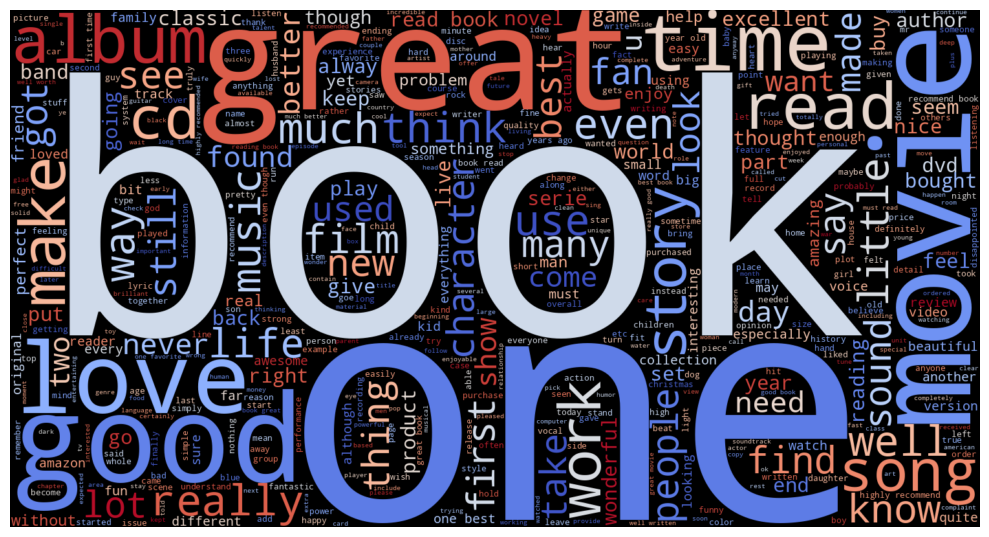

In [24]:
positive_words = " ".join(Data[Data['Polarity'] == 2]['Review'])
generate_wordcloud(positive_words)

## Застосуємо worldcloud для негативних відгуків

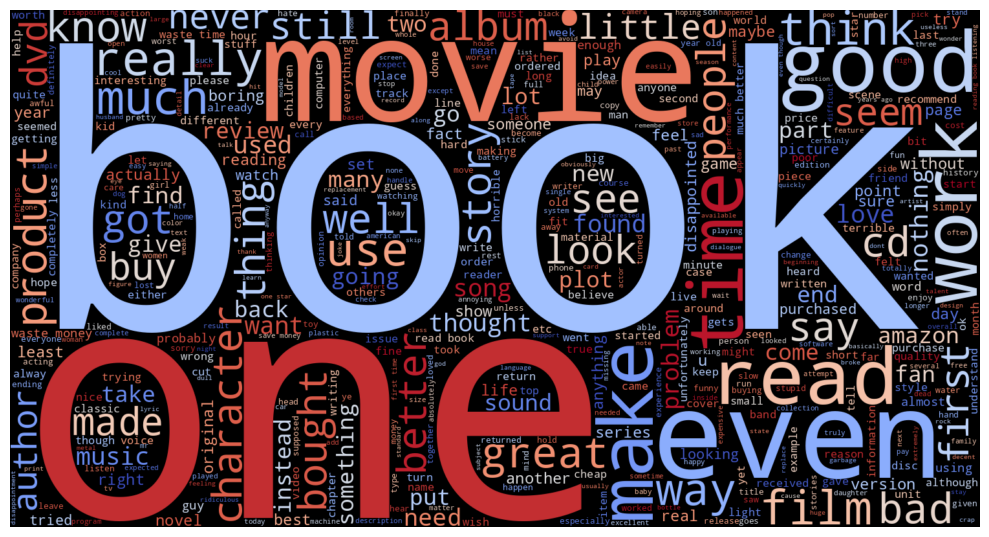

In [25]:
positive_words = " ".join(Data[Data['Polarity'] == 1]['Review'])
generate_wordcloud(positive_words)

## Векторизація із TFIDF (Term Frequency-Inverse Document Frequency)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(Data['Review'], Data['Polarity'], test_size=0.30)
tfidf_vectorizer = TfidfVectorizer(max_df=1000, min_df=10)

tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test =  tfidf_vectorizer.transform(X_test)

clf = LogisticRegression(max_iter=400).fit(tfidf_train, y_train)

predicted = clf.predict(tfidf_test)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           1       0.83      0.80      0.82      5871
           2       0.82      0.84      0.83      6129

    accuracy                           0.82     12000
   macro avg       0.82      0.82      0.82     12000
weighted avg       0.82      0.82      0.82     12000
